In [1]:
import mxnet as mx
import mxnet.ndarray as nd
from mxnet import nd, autograd, image, init, gluon
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import gluoncv as gcv
from gluoncv import model_zoo, data, utils
from gluoncv.model_zoo import get_model
from gluoncv.data.transforms import presets
from gluoncv.data.transforms.presets.segmentation import test_transform
from gluoncv.data.transforms.pose import detector_to_simple_pose, heatmap_to_coord
from gluoncv.utils.viz import get_color_pallete

import numpy as np

from matplotlib import pyplot as plt
import matplotlib.image as mpimg

In [93]:
def softmax(X, theta = 1.0, axis = None):
    """
    Compute the softmax of each element along an axis of X.

    Parameters
    ----------
    X: ND-Array. Probably should be floats.
    theta (optional): float parameter, used as a multiplier
        prior to exponentiation. Default = 1.0
    axis (optional): axis to compute values along. Default is the
        first non-singleton axis.

    Returns an array the same size as X. The result will sum to 1
    along the specified axis.
    """

    # make X at least 2d
    y = np.atleast_2d(X)

    # find axis
    if axis is None:
        axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)

    # multiply y against the theta parameter,
    y = y * float(theta)

    # subtract the max for numerical stability
    y = y - np.expand_dims(np.max(y, axis = axis), axis)

    # exponentiate y
    y = np.exp(y)

    # take the sum along the specified axis
    ax_sum = np.expand_dims(np.sum(y, axis = axis), axis)

    # finally: divide elementwise
    p = y / ax_sum

    # flatten if X was 1D
    if len(X.shape) == 1: p = p.flatten()

    return p

Broadly speaking, there are four different options when it comes to identifying objects within an image. The first, and most straightforward, is classification, where an image is fed to a network and it outputs what it thinks is the most salient object in the image. This is what ResNet50 does.

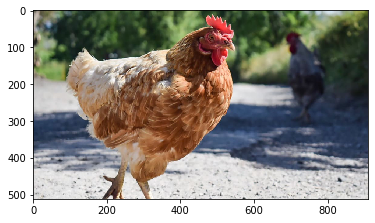

In [76]:
url = 'https://images2.minutemediacdn.com/image/upload/c_crop,h_1351,w_2400,x_0,y_99/f_auto,q_auto,w_1100/v1562683076/shape/mentalfloss/587360-gettyimages-1005040320.jpg'
im_fname = utils.download(url)

_, img = presets.ssd.load_test(im_fname, short=512)

plt.imshow(img)

In [97]:
def classify(image_fm, model, k=5, short=512):
    
    x, _ = presets.ssd.load_test(image_fm, short=short)

    pred = model(x)[0]
    probs = softmax(pred)
    
    top = nd.topk(pred, k=k)
    
    return [ (model.classes[int(x)], probs[int(x)].asnumpy()[0]) for x in top.asnumpy() ]

In [85]:
resnet50 = get_model('ResNet50_v2', pretrained=True)

In [98]:
%%time
classify(im_fname, resnet50)

Wall time: 4 s


[('hen', 0.23710415),
 ('cock', 0.18894272),
 ('partridge', 0.04794338),
 ('ruffed grouse', 0.038416676),
 ('vulture', 0.031178655)]

There are many models of varying accuracy.

<img src="classification_graph.png">

From the above, we can draw a few conclusions. If we're defaulting to ResNet50, we might as well switch to ResNet101 v1d 0.76, since it's similarly fast, but strictly more accurate and slightly lighter weight. Alternatively, ResNet50 v1d 0.86 is much faster than ResNet50 while being slightly faster, so we might as well use that.

If we want maximum accuracy (at the expense of speed), though, it's barely better than ResNet101 v1d.

In [99]:
senet = get_model('senet_154', pretrained=True)

In [107]:
%%time
classify(im_fname, senet)

Wall time: 18.5 s


[('hen', 0.3576482),
 ('cock', 0.14044781),
 ('partridge', 0.0042225975),
 ('vulture', 0.0039054765),
 ('drake', 0.0030341558)]

In [101]:
resnet101_v1d_0_76 = get_model('resnet101_v1d_0.76', pretrained=True)

In [108]:
%%time
classify(im_fname, resnet101_v1d_0_76)

Wall time: 4.92 s


[('hen', 0.0063874056),
 ('cock', 0.0043828716),
 ('partridge', 0.003086896),
 ('black grouse', 0.0025641338),
 ('ptarmigan', 0.0024303216)]

In [103]:
resnet50_v1d_0_86 = get_model('resnet50_v1d_0.86', pretrained=True)

In [109]:
%%time
classify(im_fname, resnet50_v1d_0_86)

Wall time: 3.73 s


[('hen', 0.015115836),
 ('cock', 0.013450302),
 ('partridge', 0.005863679),
 ('ruffed grouse', 0.0032223174),
 ('black grouse', 0.0030533334)]

In [105]:
resnet101_v1d = get_model('resnet101_v1d', pretrained=True)

In [110]:
%%time
classify(im_fname, resnet101_v1d)

Wall time: 6.95 s


[('hen', 0.009634589),
 ('cock', 0.0055193477),
 ('partridge', 0.004083148),
 ('ptarmigan', 0.0028965794),
 ('ruffed grouse', 0.0028512655)]

-------------------------------------------------------------------------------------------

Secondly, there are networks that detect objects and tell us where they are.

<img src="detection_graph.png">

Based on this, there are only two networks worth considering; Faster RNN ResNet101 v1d for max precision and YOLO3 for a balance between speed and precision.

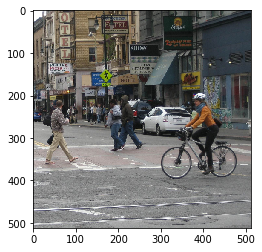

In [66]:
url = "https://cloud.githubusercontent.com/assets/3307514/20012568/cbc2d6f6-a27d-11e6-94c3-d35a9cb47609.jpg"
im_fname_st = utils.download(url)

_, img = presets.ssd.load_test(im_fname_st, short=512)

plt.imshow(img)

In [71]:
def detect(im_fname, model, thresh = 0.5, short=512):
    ax = None
    x, img = presets.ssd.load_test(im_fname, short=short)
    ids, scores, bboxes = [xx[0].asnumpy() for xx in model(x)]
    ax = gcv.utils.viz.plot_bbox(img, bboxes, scores, ids, thresh=thresh, class_names=model.classes, ax=ax)
    plt.show()

In [13]:
faster_rcnn_fpn_resnet101_v1d_coco = get_model('faster_rcnn_fpn_resnet101_v1d_coco', pretrained=True)

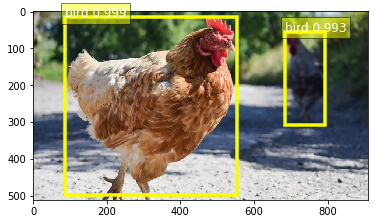

In [45]:
detect(im_fname, faster_rcnn_fpn_resnet101_v1d_coco)

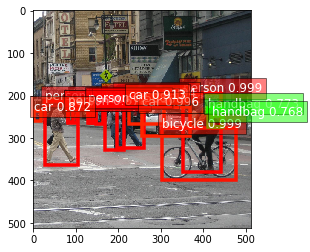

In [73]:
detect(im_fname_st, faster_rcnn_fpn_resnet101_v1d_coco)

In [74]:
yolo3_coco = get_model('yolo3_darknet53_coco', pretrained=True)

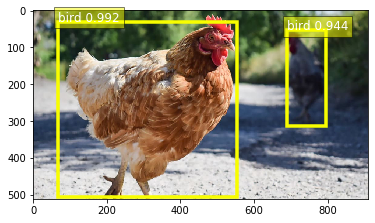

In [50]:
detect(im_fname, yolo3_coco)

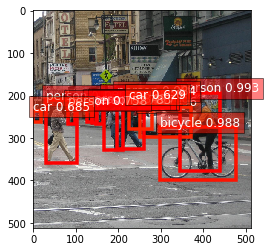

In [75]:
detect(im_fname_st, yolo3_coco)

It's important to note that these networks were trained on COCO, which has only 80 classes. The classification networks from the previous section all had 1000 classes, allowing them more accuracy. There are other training sets we can use.

In [58]:
len(yolo3_coco.classes)

80

In [5]:
yolo3_voc = get_model('yolo3_darknet53_voc', pretrained=True)

In [59]:
len(yolo3_voc.classes)

20

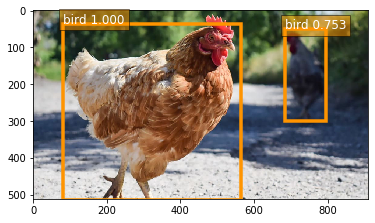

In [57]:
detect(im_fname, yolo3_voc)

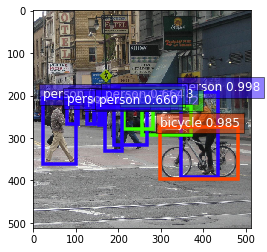

In [79]:
detect(im_fname_st, yolo3_voc)

Obviously, this is even fewer classes. It's hard to find pretrained models with many classes. Here's a version of YOLO3 trained on OpenImages.

In [135]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    yolo3_OpenImages = gluon.nn.SymbolBlock.imports("YOLO3/net.json", ['Input'], "YOLO3/net.params")

In [136]:
yolo3_OpenImages.classes = ["Tortoise", "Container", "Magpie", "Sea turtle", "Football",
"Ambulance", "Ladder", "Toothbrush", "Syringe", "Sink", "Toy",
"Organ", "Cassette deck", "Apple", "Human eye", "Cosmetics",
"Paddle", "Snowman", "Beer", "Chopsticks", "Human beard", "Bird",
"Parking meter", "Traffic light", "Croissant", "Cucumber", "Radish",
"Towel", "Doll", "Skull", "Washing machine", "Glove", "Tick", "Belt",
"Sunglasses", "Banjo", "Cart", "Ball", "Backpack", "Bicycle", "Home appliance",
"Centipede", "Boat", "Surfboard", "Boot", "Headphones",
"Hot dog", "Shorts", "Fast food", "Bus", "Boy", "Screwdriver",
"Bicycle wheel", "Barge", "Laptop", "Miniskirt", "Drill", "Dress",
"Bear", "Waffle", "Pancake", "Brown bear", "Woodpecker", "Blue jay",
"Pretzel", "Bagel", "Tower", "Teapot", "Person", "Bow and arrow",
"Swimwear", "Beehive", "Brassiere", "Bee", "Bat", "Starfish",
"Popcorn", "Burrito", "Chainsaw", "Balloon", "Wrench", "Tent",
"Vehicle registration plate", "Lantern", "Toaster", "Flashlight",
"Billboard", "Tiara", "Limousine", "Necklace", "Carnivore",
"Scissors", "Stairs", "Computer keyboard", "Printer", "Traffic sign",
"Chair", "Shirt", "Poster", "Cheese", "Sock", "Fire hydrant",
"Land vehicle", "Earrings", "Tie", "Watercraft", "Cabinetry", "Suitcase",
"Muffin", "Bidet", "Snack", "Snowmobile", "Clock", "Medical equipment",
"Cattle", "Cello", "Jet ski", "Camel", "Coat", "Suit",
"Desk", "Cat", "Bronze sculpture", "Juice", "Gondola", "Beetle",
"Cannon", "Computer mouse", "Cookie", "Office building", "Fountain",
"Coin", "Calculator", "Cocktail", "Computer monitor", "Box",
"Stapler", "Christmas tree", "Cowboy hat", "Hiking equipment",
"Studio couch", "Drum", "Dessert", "Wine rack", "Drink", "Zucchini",
"Ladle", "Human mouth", "Dairy", "Dice", "Oven", "Dinosaur",
"Ratchet", "Couch", "Cricket ball", "Winter melon", "Spatula",
"Whiteboard", "Pencil sharpener", "Door", "Hat", "Shower", "Eraser",
"Fedora", "Guacamole", "Dagger", "Scarf", "Dolphin", "Sombrero",
"Tin can", "Mug", "Tap", "Harbor seal", "Stretcher", "Can opener",
"Goggles", "Human body", "Roller skates", "Coffee cup", "Cutting board",
"Blender", "Plumbing fixture", "Stop sign", "Office supplies",
"Volleyball", "Vase", "Slow cooker", "Wardrobe", "Coffee",
"Whisk", "Paper towel", "Personal care", "Food", "Sun hat", "Tree house",
"Flying disc", "Skirt", "Gas stove", "Salt and pepper shakers",
"Mechanical fan", "Face powder", "Fax", "Fruit", "French fries",
"Nightstand", "Barrel", "Kite", "Tart", "Treadmill", "Fox",
"Flag", "Horn", "Window blind", "Human foot", "Golf cart", "Jacket",
"Egg", "Street light", "Guitar", "Pillow", "Human leg", "Isopod",
"Grape", "Human ear", "Power plugs and sockets", "Panda", "Giraffe",
"Woman", "Door handle", "Rhinoceros", "Bathtub", "Goldfish",
"Houseplant", "Goat", "Baseball bat", "Baseball glove", "Mixing bowl",
"Marine invertebrates", "Kitchen utensil", "Light switch",
"House", "Horse", "Stationary bicycle", "Hammer", "Ceiling fan",
"Sofa bed", "Adhesive tape", "Harp", "Sandal", "Bicycle helmet",
"Saucer", "Harpsichord", "Human hair", "Heater", "Harmonica",
"Hamster", "Curtain", "Bed", "Kettle", "Fireplace", "Scale",
"Drinking straw", "Insect", "Hair dryer", "Kitchenware", "Indoor rower",
"Invertebrate", "Food processor", "Bookcase", "Refrigerator",
"Wood-burning stove", "Punching bag", "Common fig", "Cocktail shaker",
"Jaguar", "Golf ball", "Fashion accessory", "Alarm clock",
"Filing cabinet", "Artichoke", "Table", "Tableware", "Kangaroo",
"Koala", "Knife", "Bottle", "Bottle opener", "Lynx", "Lavender",
"Lighthouse", "Dumbbell", "Human head", "Bowl", "Humidifier",
"Porch", "Lizard", "Billiard table", "Mammal", "Mouse", "Motorcycle",
"Musical instrument", "Swim cap", "Frying pan", "Snowplow", "Bathroom cabinet",
"Missile", "Bust", "Man", "Waffle iron", "Milk", "Ring binder",
"Plate","Mobile phone", "Baked goods", "Mushroom",
"Crutch", "Pitcher", "Mirror", "Lifejacket", "Table tennis racket",
"Pencil case", "Musical keyboard", "Scoreboard", "Briefcase",
"Kitchen knife", "Nail", "Tennis ball", "Plastic bag", "Oboe",
"Chest of drawers", "Ostrich", "Piano", "Girl", "Plant", "Potato", "Hair spray",
"Sports equipment", "Pasta", "Penguin", "Pumpkin", "Pear",
"Infant bed", "Polar bear", "Mixer", "Cupboard", "Jacuzzi", "Pizza",
"Digital clock", "Pig", "Reptile", "Rifle", "Lipstick", "Skateboard",
"Raven", "High heels", "Red panda", "Rose", "Rabbit", "Sculpture",
"Saxophone", "Shotgun", "Seafood", "Submarine sandwich", "Snowboard",
"Sword", "Picture frame", "Sushi", "Loveseat", "Ski", "Squirrel",
"Tripod", "Stethoscope", "Submarine", "Scorpion", "Segway",
"Training bench", "Snake", "Coffee table", "Skyscraper", "Sheep", "Television",
"Trombone", "Tea", "Tank", "Taco", "Telephone", "Torch", "Tiger",
"Strawberry", "Trumpet", "Tree", "Tomato", "Train", "Tool", "Picnic basket",
"Cooking spray", "Trousers", "Bowling equipment",
"Football helmet", "Truck", "Measuring cup", "Coffeemaker", "Violin",
"Vehicle", "Handbag", "Paper cutter", "Wine", "Weapon", "Wheel",
"Worm", "Wok", "Whale", "Zebra", "Auto part", "Jug", "Pizza cutter",
"Cream", "Monkey", "Lion", "Bread", "Platter", "Chicken", "Eagle",
"Helicopter", "Owl", "Duck", "Turtle", "Hippopotamus", "Crocodile",
"Toilet", "Toilet paper", "Squid", "Clothing", "Footwear", "Lemon",
"Spider", "Deer", "Frog", "Banana", "Rocket", "Wine glass",
"Countertop", "Tablet computer", "Waste container", "Swimming pool",
"Dog", "Book", "Elephant", "Shark", "Candle", "Leopard", "Axe",
"Hand dryer", "Soap dispenser", "Porcupine", "Flower", "Canary", "Cheetah",
"Palm tree", "Hamburger", "Maple", "Building", "Fish", "Lobster",
"Asparagus", "Furniture", "Hedgehog", "Airplane", "Spoon", "Otter",
"Bull", "Oyster", "Horizontal bar", "Convenience store", "Bomb",
"Bench", "Ice cream", "Caterpillar", "Butterfly", "Parachute",
"Orange", "Antelope", "Beaker", "Moths and butterflies", "Window",
"Closet", "Castle", "Jellyfish", "Goose", "Mule", "Swan", "Peach",
"Coconut", "Seat belt", "Raccoon", "Chisel", "Fork", "Lamp",
"Camera", "Squash", "Racket", "Human face", "Human arm", "Vegetable",
"Diaper", "Unicycle", "Falcon", "Chime", "Snail", "Shellfish",
"Cabbage", "Carrot", "Mango", "Jeans", "Flowerpot", "Pineapple",
"Drawer", "Stool", "Envelope", "Cake", "Dragonfly", "Sunflower",
"Microwave oven", "Honeycomb", "Marine mammal", "Sea lion",
"Ladybug", "Shelf", "Watch", "Candy", "Salad", "Parrot", "Handgun",
"Sparrow", "Van", "Grinder", "Spice rack", "Light bulb", "Corded phone",
"Sports uniform", "Tennis racket", "Wall clock", "Serving tray",
"Kitchen & dining room table", "Dog bed", "Cake stand", "Cat furniture",
"Bathroom accessory", "Facial tissue holder", "Pressure cooker",
"Kitchen appliance", "Tire", "Ruler", "Luggage and bags",
"Microphone", "Broccoli", "Umbrella", "Pastry", "Grapefruit",
"Band-aid", "Animal", "Bell pepper", "Turkey", "Lily", "Pomegranate",
"Doughnut", "Glasses", "Human nose", "Pen", "Ant", "Car", "Aircraft",
"Human hand", "Skunk", "Teddy bear", "Watermelon", "Cantaloupe",
"Dishwasher", "Flute", "Balance beam", "Sandwich", "Shrimp", "Sewing machine",
   "Binoculars", "Rays and skates", "Ipod", "Accordion",
"Willow", "Crab", "Crown", "Seahorse", "Perfume", "Alpaca", "Taxi",
"Canoe", "Remote control", "Wheelchair", "Rugby ball", "Armadillo",
"Maracas", "Helmet"]

In [137]:
len(yolo3_OpenImages.classes)

601

In [144]:
def yolo3_OpenImages_detect(im_fname, thresh=0.9):
    short = 608
    
    model = yolo3_OpenImages
    
    img = image.imread(im_fname)
    
    ys, xs, _ = [ x / short for x in img.shape ]
    
    transform_fn = transforms.Compose([
        transforms.Resize(short),
        transforms.CenterCrop(short),
        transforms.ToTensor()
    ])
    
    simg = transform_fn(img)
    simg = simg.expand_dims(0)
    
    bboxes, ids, scores = [xx[0].asnumpy() for xx in model(simg)]

    scores = scores.reshape(-1,1)
    ids = ids.argmax(axis=1).reshape(-1,1)
    # Note: the output of the network assumes that (0,0) is at the bottom left of the image
    # and the coordinates increase as one goes up. gluoncv assumes that (0,0) is the top-left, and
    # the coordinates increase as one goes down. This converts one into the other.
    bboxes = [ [xs * x1, ys * (short - y2), xs * x2, ys * (short - y1)] for [[x1, y1], [x2, y2]] in bboxes ]
    
    ax = None
    ax = gcv.utils.viz.plot_bbox(img, bboxes, scores, ids, thresh=thresh, class_names=model.classes, ax=ax)
    plt.show()

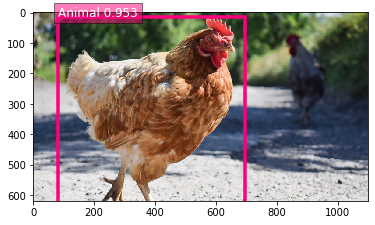

In [145]:
yolo3_OpenImages_detect(im_fname)

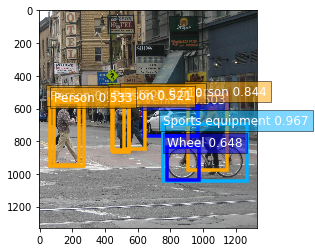

In [87]:
yolo3_OpenImages_detect(im_fname_st, thresh=0.5)

In [25]:
url = "https://www.bchtechnologies.com/media/catalog/product/cache/1/image/9df78eab33525d08d6e5fb8d27136e95/2/_/2_16.jpg"
im_fname_sy = utils.download(url)

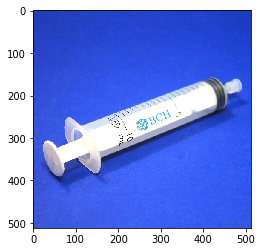

In [148]:
detect(im_fname_sy, yolo3_voc)

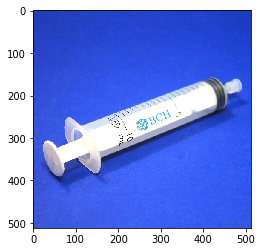

In [149]:
detect(im_fname_sy, yolo3_coco)

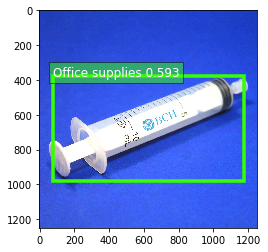

In [26]:
yolo3_OpenImages_detect(im_fname_sy, thresh=.5)

It's not really correct, but it will give more feedback than the other networks.

Overall, I'm somewhat disappointed in object detection networks. They don't actually work that well outside of classifying maybe a dozen specific classes. If you don't know what a dog or airplane is, then these might be useful. In practice, if you can't identify something, then, in all likelihood, these networks have no chance either.

-------------------------------------------------------------------------------------------

The third option is semantic segmentation. This involves creating a mask over all the regions within the image. There aren't many options, so I'll just show off all of them.

<img src="segmentation_graph.png">

In [30]:
def segment(im_fname, model, short = 512):
    x, img = presets.ssd.load_test(im_fname, short=short)
    
    output = model.predict(x)
    predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()

    mask = get_color_pallete(predict, 'pascal_voc')
    
    plt.imshow(mask)

In [37]:
fcn_resnet101_voc = gcv.model_zoo.get_model('fcn_resnet101_voc', pretrained=True)

Wall time: 22.4 s


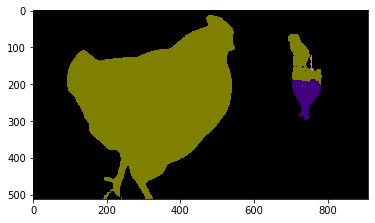

In [36]:
%%time
segment(im_fname, fcn_resnet101_voc)

In [39]:
psp_resnet101_voc = gcv.model_zoo.get_model('psp_resnet101_voc', pretrained=True)

self.crop_size 480


Wall time: 28.8 s


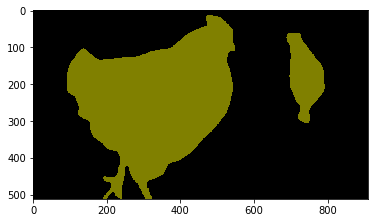

In [40]:
%%time
segment(im_fname, psp_resnet101_voc)

In [43]:
deeplab_resnet101_voc = gcv.model_zoo.get_model('deeplab_resnet101_voc', pretrained=True)

Wall time: 29.2 s


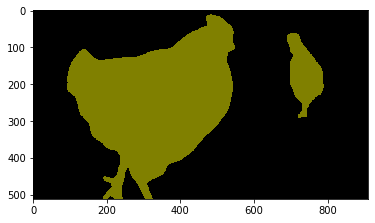

In [44]:
%%time
segment(im_fname, deeplab_resnet101_voc)

In [46]:
deeplab_resnet152_voc = gcv.model_zoo.get_model('deeplab_resnet152_voc', pretrained=True)

Wall time: 34.4 s


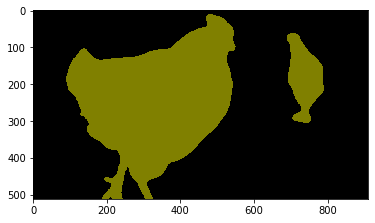

In [47]:
%%time
segment(im_fname, deeplab_resnet152_voc)

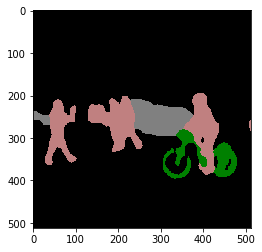

In [53]:
segment(im_fname_st, deeplab_resnet152_voc)

The last option is neural image captioning. Such networks use a mixture of NLP text generators and image processing to produce a textual, usually sentence-long, description of the image contents.

Unfortunately, this sort of network is less mature, and I had a hard time finding any pretrained models. Most of what I did find was spread across pytorch, chainer, keras, python 2.7 and 3.x, etc. meaning many existing models couldn't be used. This is why I prefer MXNet. If these networks were made in MXNet in the first place, then it wouldn't matter where they were made, they could be imported and exported anywhere, but I digress.

I couldn't get any of them to work! I might be able to train my own, if people think it's worthwhile, but for the moment, you'll have to just use your imagination...





=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=








Outside of that, there are many special-purpose networks for extracting specific information. Here's a rundown of a few examples;

Pose estimation:

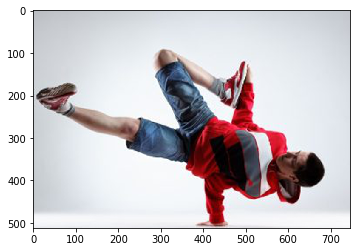

In [2]:
url = 'https://www.the-elbowroom.com/wp-content/uploads/2017/09/shutterstock_115483441-e1504870688635-360x247.jpg'
im_fname_bd = utils.download(url)

_, img = presets.ssd.load_test(im_fname_bd, short=512)

plt.imshow(img)

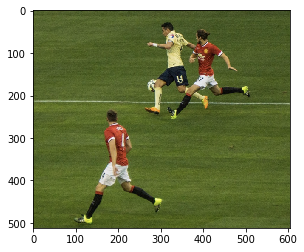

In [3]:
url = 'https://github.com/dmlc/web-data/raw/master/gluoncv/pose/soccer.png'

im_fname_sc = utils.download(url)

_, img = presets.ssd.load_test(im_fname_sc, short=512)

plt.imshow(img)

In [9]:
def pose_detect(image_fm, detector, pose_net, thresh=0.5, short=512):
    detector.reset_class(["person"], reuse_weights=['person'])
    
    x, img = data.transforms.presets.ssd.load_test(image_fm, short=short)
    
    class_IDs, scores, bounding_boxs = detector(x)
    
    pose_input, upscale_bbox = detector_to_simple_pose(img, class_IDs, scores, bounding_boxs)
    
    predicted_heatmap = pose_net(pose_input)
    pred_coords, confidence = heatmap_to_coord(predicted_heatmap, upscale_bbox)
    
    ax = utils.viz.plot_keypoints(img, pred_coords, confidence,
                                  class_IDs, bounding_boxs, scores,
                                  box_thresh=thresh, keypoint_thresh=0.2)
    plt.show()

In [7]:
simple_pose_resnet18_v1b = model_zoo.get_model('simple_pose_resnet18_v1b', pretrained=True)

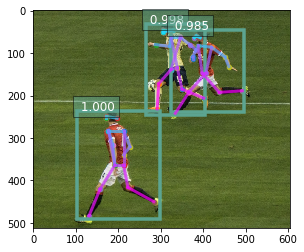

In [10]:
pose_detect(im_fname_sc, yolo3_voc, simple_pose_resnet18_v1b)

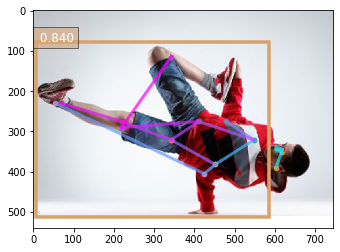

In [11]:
pose_detect(im_fname_bd, yolo3_voc, simple_pose_resnet18_v1b)

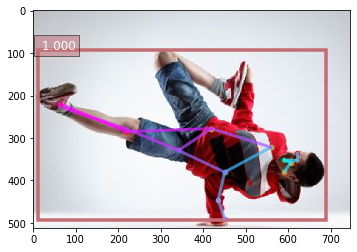

In [14]:
pose_detect(im_fname_bd, faster_rcnn_fpn_resnet101_v1d_coco, simple_pose_resnet18_v1b)

In [16]:
alpha_pose_resnet101_v1b_coco = model_zoo.get_model('alpha_pose_resnet101_v1b_coco', pretrained=True)

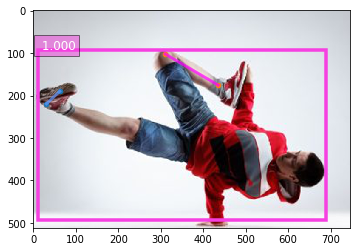

In [17]:
pose_detect(im_fname_bd, faster_rcnn_fpn_resnet101_v1d_coco, alpha_pose_resnet101_v1b_coco)

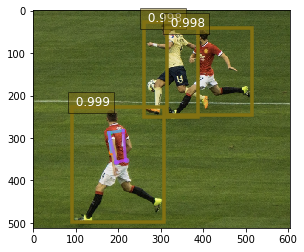

In [18]:
pose_detect(im_fname_sc, faster_rcnn_fpn_resnet101_v1d_coco, alpha_pose_resnet101_v1b_coco)

----------------------------------

Geolocation Identification:

In [4]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    resnet101_YFCC100m = gluon.nn.SymbolBlock.imports("GeoLocate/net.json", ['Input'], "GeoLocate/net.params")

In [16]:
resnet101_YFCC100m.classes = []

f = open("GeoLocate/labels.txt", "r")

for _ in range(15527):
    resnet101_YFCC100m.classes.append(tuple(map(float,f.readline().split())))

f.close()

In [9]:
def resnet101_YFCC100m_predict(im_fname, thresh=0.9, k=1, short = 608):
    model = resnet101_YFCC100m
    
    img = image.imread(im_fname)
    
    transform_fn = transforms.Compose([
        transforms.Resize(short),
        transforms.CenterCrop(short),
        transforms.ToTensor()
    ])
    
    simg = transform_fn(img)
    simg = simg.expand_dims(0)
    
    probs = model(simg)
    
    top = nd.topk(probs, k=k)[0]
    
    return [ model.classes[int(x)] for x in top.asnumpy() ]

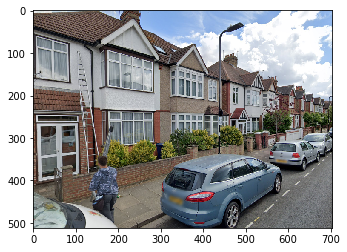

In [7]:
url = "geo_test_london.png"
im_fname_geo = utils.download(url)

_, img = presets.ssd.load_test(im_fname_geo, short=512)

plt.imshow(img)

In [11]:
resnet101_YFCC100m_predict(im_fname_geo)

[(51.5263, -0.230007)]

This is in London, which is, indeed, where that photo was taken.

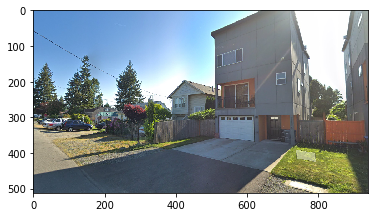

In [13]:
url = "geo_test_seattle.png"
im_fname_geo2 = utils.download(url)

_, img = presets.ssd.load_test(im_fname_geo2, short=512)

plt.imshow(img)

In [14]:
resnet101_YFCC100m_predict(im_fname_geo2)

[(36.948, -121.498)]

It guessed Gilroy, CA, which is wrong, but not that far off on a global scale.

----------------------------------

Age estimation:

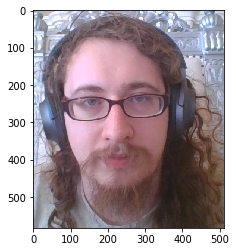

In [17]:
url = "test_photo.jpg"
im_fname_me = utils.download(url)

_, img = presets.ssd.load_test(im_fname_me, short=512)

plt.imshow(img)

Note that photos of properly-framed faces are neccessary for accuracy. Some setups auto-crop photos using separate face-detection, but these networks won't do that on their own.

In [18]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    vgg16_IMDBWIKI_LaP = gluon.nn.SymbolBlock.imports("VGG_AGE/net.json", ['Input'], "VGG_AGE/net.params")

In [30]:
def vgg16_IMDBWIKI_LaP_estimate(im_fname, thresh=0.9, k=1, short = 224):
    model = vgg16_IMDBWIKI_LaP
    
    img = image.imread(im_fname)
    
    transform_fn = transforms.Compose([
        transforms.Resize(short),
        transforms.CenterCrop(short),
        transforms.ToTensor()
    ])
    
    simg = transform_fn(img)
    simg = simg.expand_dims(0)
    
    probs = model(simg)
    
    top = nd.topk(probs, k=k)[0]
    
    return top

In [43]:
vgg16_IMDBWIKI_LaP_estimate(im_fname_me)


[28.]
<NDArray 1 @cpu(0)>

Pretty close.

----------------------------------

Sex Prediction:

In [44]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    vgg16_IMDBWIKI = gluon.nn.SymbolBlock.imports("VGG_SEX/net.json", ['Input'], "VGG_SEX/net.params")

In [47]:
vgg16_IMDBWIKI.classes = ['Female', 'Male']

In [54]:
def vgg16_IMDBWIKI_prediction(im_fname, short = 224):
    model = vgg16_IMDBWIKI
    
    img = image.imread(im_fname)
    
    transform_fn = transforms.Compose([
        transforms.Resize(short),
        transforms.CenterCrop(short),
        transforms.ToTensor()
    ])
    
    simg = transform_fn(img)
    simg = simg.expand_dims(0)
    
    probs = model(simg)
    
    top = int(nd.topk(probs, k=1)[0].asnumpy()[0])
    
    return model.classes[top]

In [55]:
vgg16_IMDBWIKI_prediction(im_fname_me)

'Male'

Pretty close.

----------------------------------

Location Classification:

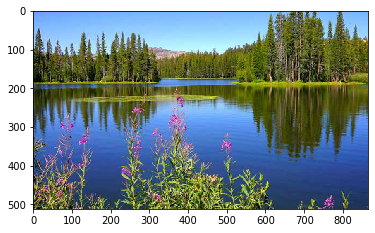

In [2]:
url = 'https://slcwd.org/assets/site/serene-lake-aed13e3195448c6dd9d2e5beab4736763abcf7d0a57af1d982d20add4d46dd51.jpg'
im_fname_lk = utils.download(url)

_, img = presets.ssd.load_test(im_fname_lk, short=512)

plt.imshow(img)

In [56]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    inception_v1_places365 = gluon.nn.SymbolBlock.imports("InceptionV1Places365/net.json", ['Input'], "InceptionV1Places365/net.params")

In [57]:
inception_v1_places365.classes = ["Airfield", "Airplane Cabin", "Airport Terminal", "Alcove", "Alley", "Amphitheater", "Amusement Arcade", "Amusement Park", "Apartment Building, Outdoor", "Aquarium", "Aqueduct", "Arcade", "Arch", "Archaelogical Excavation", "Archive", "Arena, Hockey", "Arena, Performance", "Arena, Rodeo", "Army Base", "Art Gallery", "Art School", "Art Studio", "Artists Loft", "Assembly Line", "Athletic Field, Outdoor", "Atrium, Public", "Attic", "Auditorium", "Auto Factory", "Auto Showroom", "Badlands", "Bakery, Shop", "Balcony, Exterior", "Balcony, Interior", "Ball Pit", "Ballroom", "Bamboo Forest", "Bank Vault", "Banquet Hall", "Bar", "Barn", "Barndoor", "Baseball Field", "Basement", "Basketball Court, Indoor", "Bathroom", "Bazaar, Indoor", "Bazaar, Outdoor", "Beach", "Beach House", "Beauty Salon", "Bedchamber", "Bedroom", "Beer Garden", "Beer Hall", "Berth", "Biology Laboratory", "Boardwalk", "Boat Deck", "Boathouse", "Bookstore", "Booth, Indoor", "Botanical Garden", "Bow Window, Indoor", "Bowling Alley", "Boxing Ring", "Bridge", "Building Facade", "Bullring", "Burial Chamber", "Bus Interior", "Bus Station, Indoor", "Butchers Shop", "Butte", "Cabin, Outdoor", "Cafeteria", "Campsite", "Campus", "Canal, Natural", "Canal, Urban", "Candy Store", "Canyon", "Car Interior", "Carrousel", "Castle", "Catacomb", "Cemetery", "Chalet", "Chemistry Lab", "Childs Room", "Church, Indoor", "Church, Outdoor", "Classroom", "Clean Room", "Cliff", "Closet", "Clothing Store", "Coast", "Cockpit", "Coffee Shop", "Computer Room", "Conference Center", "Conference Room", "Construction Site", "Corn Field", "Corral", "Corridor", "Cottage", "Courthouse", "Courtyard", "Creek", "Crevasse", "Crosswalk", "Dam", "Delicatessen", "Department Store", "Desert, Sand", "Desert, Vegetation", "Desert Road", "Diner, Outdoor", "Dining Hall", "Dining Room", "Discotheque", "Doorway, Outdoor", "Dorm Room", "Downtown", "Dressing Room", "Driveway", "Drugstore", "Elevator, Door", "Elevator Lobby", "Elevator Shaft", "Embassy", "Engine Room", "Entrance Hall", "Escalator, Indoor", "Excavation", "Fabric Store", "Farm", "Fastfood Restaurant", "Field, Cultivated", "Field, Wild", "Field Road", "Fire Escape", "Fire Station", "Fishpond", "Flea Market, Indoor", "Florist Shop, Indoor", "Food Court", "Football Field", "Forest, Broadleaf", "Forest Path", "Forest Road", "Formal Garden", "Fountain", "Galley", "Garage, Indoor", "Garage, Outdoor", "Gas Station", "Gazebo, Exterior", "General Store, Indoor", "General Store, Outdoor", "Gift Shop", "Glacier", "Golf Course", "Greenhouse, Indoor", "Greenhouse, Outdoor", "Grotto", "Gymnasium, Indoor", "Hangar, Indoor", "Hangar, Outdoor", "Harbor", "Hardware Store", "Hayfield", "Heliport", "Highway", "Home Office", "Home Theater", "Hospital", "Hospital Room", "Hot Spring", "Hotel, Outdoor", "Hotel Room", "House", "Hunting Lodge, Outdoor", "Ice Cream Parlor", "Ice Floe", "Ice Shelf", "Ice Skating Rink, Indoor", "Ice Skating Rink, Outdoor", "Iceberg", "Igloo", "Industrial Area", "Inn, Outdoor", "Islet", "Jacuzzi, Indoor", "Jail Cell", "Japanese Garden", "Jewelry Shop", "Junkyard", "Kasbah", "Kennel, Outdoor", "Kindergarden Classroom", "Kitchen", "Lagoon", "Lake, Natural", "Landfill", "Landing Deck", "Laundromat", "Lawn", "Lecture Room", "Legislative Chamber", "Library, Indoor", "Library, Outdoor", "Lighthouse", "Living Room", "Loading Dock", "Lobby", "Lock Chamber", "Locker Room", "Mansion", "Manufactured Home", "Market, Indoor", "Market, Outdoor", "Marsh", "Martial Arts Gym", "Mausoleum", "Medina", "Mezzanine", "Moat, Water", "Mosque, Outdoor", "Motel", "Mountain", "Mountain Path", "Mountain Snowy", "Movie Theater, Indoor", "Museum, Indoor", "Museum, Outdoor", "Music Studio", "Natural History Museum", "Nursery", "Nursing Home", "Oast House", "Ocean", "Office", "Office Building", "Office Cubicles", "Oilrig", "Operating Room", "Orchard", "Orchestra Pit", "Pagoda", "Palace", "Pantry", "Park", "Parking Garage, Indoor", "Parking Garage, Outdoor", "Parking Lot", "Pasture", "Patio", "Pavilion", "Pet Shop", "Pharmacy", "Phone Booth", "Physics Laboratory", "Picnic Area", "Pier", "Pizzeria", "Playground", "Playroom", "Plaza", "Pond", "Porch", "Promenade", "Pub, Indoor", "Racecourse", "Raceway", "Raft", "Railroad Track", "Rainforest", "Reception", "Recreation Room", "Repair Shop", "Residential Neighborhood", "Restaurant", "Restaurant Kitchen", "Restaurant Patio", "Rice Paddy", "River", "Rock Arch", "Roof Garden", "Rope Bridge", "Ruin", "Runway", "Sandbox", "Sauna", "Schoolhouse", "Science Museum", "Server Room", "Shed", "Shoe Shop", "Shopfront", "Shopping Mall, Indoor", "Shower", "Ski Resort", "Ski Slope", "Sky", "Skyscraper", "Slum", "Snowfield", "Soccer Field", "Stable", "Stadium, Baseball", "Stadium, Football", "Stadium, Soccer", "Stage, Indoor", "Stage, Outdoor", "Staircase", "Storage Room", "Street", "Subway Station, Platform", "Supermarket", "Sushi Bar", "Swamp", "Swimming Hole", "Swimming Pool, Indoor", "Swimming Pool, Outdoor", "Synagogue, Outdoor", "Television Room", "Television Studio", "Temple, Asia", "Throne Room", "Ticket Booth", "Topiary Garden", "Tower", "Toyshop", "Train Interior", "Train Station, Platform", "Tree Farm", "Tree House", "Trench", "Tundra", "Underwater, Ocean Deep", "Utility Room", "Valley", "Vegetable Garden", "Veterinarians Office", "Viaduct", "Village", "Vineyard", "Volcano", "Volleyball Court, Outdoor", "Waiting Room", "Water Park", "Water Tower", "Waterfall", "Watering Hole", "Wave", "Wet Bar", "Wheat Field", "Wind Farm", "Windmill", "Yard", "Youth Hostel", "Zen Garden"]

In [147]:
def inception_v1_places365_classify(im_fname, k=1, short = 224):
    model = inception_v1_places365
    
    img = image.imread(im_fname)
    
    transform_fn = transforms.Compose([
        transforms.Resize(short),
        transforms.CenterCrop(short),
        transforms.ToTensor()
    ])
    
    simg = transform_fn(img)
    simg = simg.expand_dims(0)
    
    probs = model(simg)
    
    top = nd.topk(probs, k=k)[0]
    
    return [ model.classes[int(x)] for x in top.asnumpy() ]

In [65]:
inception_v1_places365_classify(im_fname_lk)

['Lake, Natural']

Hmmm...

----------------------------------

Depth Perception:

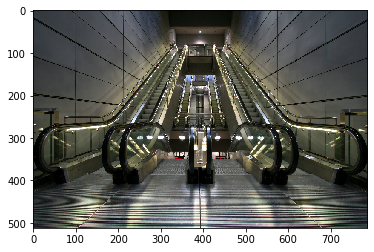

In [3]:
url = 'https://upload.wikimedia.org/wikipedia/commons/4/42/Copenhagen_Metro_escalators.jpg'
im_fname_es = utils.download(url)

_, img = presets.ssd.load_test(im_fname_es, short=512)

plt.imshow(img)

In [4]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sidp_NYU_depth_V2_DitW = gluon.nn.SymbolBlock.imports("SIDP/net.json", ['Input'], "SIDP/net.params")

In [5]:
def sidp_NYU_depth_V2_DitW_depthmap(im_fname):
    model = sidp_NYU_depth_V2_DitW
    width = 320
    height = 240

    img = image.imread(im_fname)

    transform_fn = transforms.Compose([
            transforms.Resize((width, height)),
            transforms.ToTensor()
        ])

    simg = transform_fn(img).expand_dims(0)

    out = sidp_NYU_depth_V2_DitW(simg)[0]

    plt.imshow(out.asnumpy())

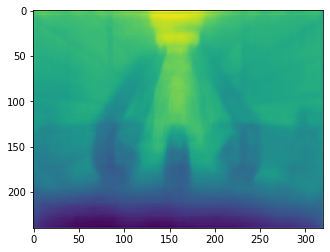

In [6]:
sidp_NYU_depth_V2_DitW_depthmap(im_fname_es)

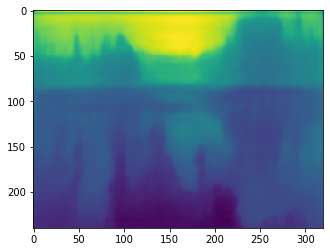

In [7]:
sidp_NYU_depth_V2_DitW_depthmap(im_fname_lk)

----------------------------------

NSFW Identification:

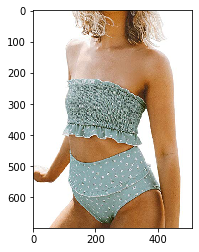

In [12]:
url = 'https://images-na.ssl-images-amazon.com/images/I/71IBm0widHL._UY606_.jpg'
im_fname_bs = utils.download(url)

_, img = presets.ssd.load_test(im_fname_bs, short=512)

plt.imshow(img)

In [8]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    yahoo_open_NSFW_v1  = gluon.nn.SymbolBlock.imports("yahoo_nsfw/net.json", ['Input'], "yahoo_nsfw/net.params")

In [9]:
yahoo_open_NSFW_v1.classes = ['Safe', 'Not Safe']

In [14]:
def yahoo_open_NSFW_classify(im_fname, short = 224):
    model = yahoo_open_NSFW_v1
    
    img = image.imread(im_fname)
    
    transform_fn = transforms.Compose([
        transforms.Resize(short),
        transforms.CenterCrop(short),
        transforms.ToTensor()
    ])
    
    simg = transform_fn(img)
    simg = simg.expand_dims(0)
    
    probs = model(simg)
        
    return [ (c, p) for c, p in zip(model.classes, probs[0].asnumpy()) ]

In [15]:
yahoo_open_NSFW_classify(im_fname_bs)

[('Safe', 0.99999976), ('Not Safe', 2.1039597e-07)]

I've actually found the network to be not that accurate. I'll leave it to you to test this.

----------------------------------

Audio Identification:

It should be posssible to identify audio using an audioclassification network fed with a spectrograph. I didn't take the time to actually set this up, but I did get a Wolfram AudioIdentify V1 network running in Mathematica, I just didn't want to spend the time porting it over to python, though I could, if it was worth the time.

In [ ]:
...